### A workbook where we developed the leaf area extraction pipeline

**In progress:**
* "Scamtron" integration - allows users to encode up to five categorical parameters in images
* Improve "sus_list" function for automatically removing low quality leaf area measurements from curated dataset

In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import skimage
from skimage import io
from skimage.filters import threshold_local
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
# set image name
imageName = 'photos/IMG_0672.jpeg'

# load the image
image = cv2.imread(imageName)

# compute ratio of old height to the new height, clone it and resize it
ratio = image.shape[0] / 1000.0
orig = image.copy()
image = imutils.resize(image, height = 1000)

# convert resized image to grayscale, blur it slightly, then find edges
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

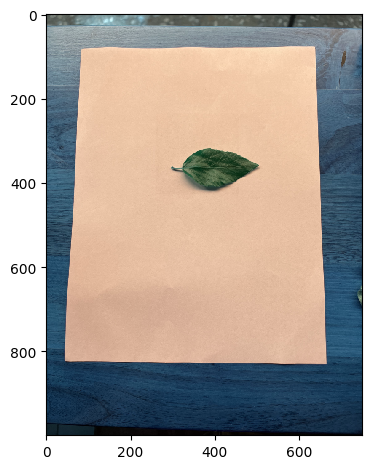

In [3]:
io.imshow(image) # check image
io.show()

# io.imshow(edged[500:800,100:300]) # check bubbles found with Canny edge detector
# io.show()

# io.imshow(edged[50:250,:200]) # approx top left edge
# io.show()

# io.imshow(edged[50:250,500:700]) # approx top right edge
# io.show()

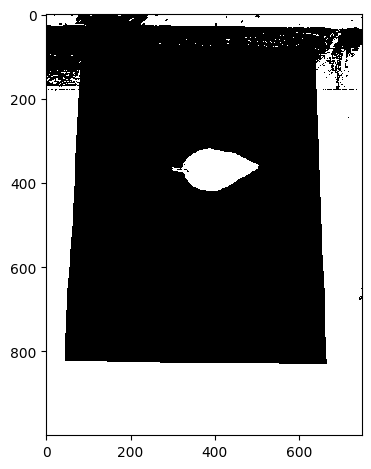

In [4]:
# apply Otsu's thresholding method to binarize
thresh3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

io.imshow(thresh3) # check thresholded image
io.show()

In [5]:
# find contours in the edge map, keeping only the largest ones, then initialize the paper contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
# 		print("hello")
		break

In [6]:
# apply the four point transform to obtain a top-down view of the original image
warped2 = four_point_transform(thresh3, screenCnt.reshape(4, 2))
warped_color = four_point_transform(image, screenCnt.reshape(4, 2))

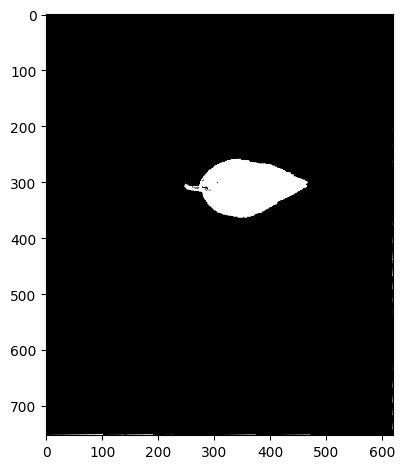

In [7]:
io.imshow(warped2) # check warped image
io.show()

# io.imshow(warped2[575:800,:225])
# io.show()

# print(warped2.shape[0])
# print(warped2.shape[1])

# print(warped2.shape[0] * 0.0556)
# print(warped2.shape[0] * 0.013)
# print(warped2.shape[1] * 0.076)
# print(warped2.shape[1] * 0.0126)

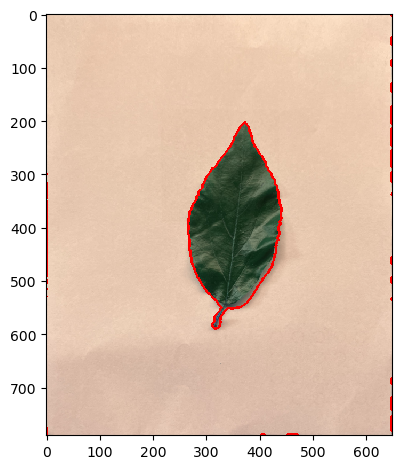

In [11]:
# find contours in the thresholded and warped image, then initialize the list of contours that correspond to bubbles
cnts = cv2.findContours(warped2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# questionCnts = []
# # loop over the contours
# for c in cnts:
# 	# compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
# 	(x, y, w, h) = cv2.boundingRect(c)
# 	ar = w / float(h)
# 	# in order to label the contour as a question, region should be sufficiently wide, sufficiently tall, and 
#     # have an aspect ratio approximately equal to 1
# # 	if warped2.shape[1] * 0.066 >= w >= warped2.shape[1] * 0.0166 and warped2.shape[1] * 0.0456 >= h >= warped2.shape[1] * 0.0137 and ar >= 0.85 and ar <= 1.15:
# # 		questionCnts.append(c)
# 	if warped2.shape[1] * 0.076 >= w >= warped2.shape[1] * 0.0126 and warped2.shape[1] * 0.0556 >= h >= warped2.shape[1] * 0.013 and ar >= 0.85 and ar <= 1.15:
# 		questionCnts.append(c)
# 	color = (255, 0, 0) # red
# 	# draw the outline of the bubble on the test
# 	cv2.drawContours(warped_color, cnts, -1, color, 3)

color = (255, 0, 0) # red
# draw the outline of the bubble on the test
cv2.drawContours(warped_color, cnts, -1, color, 3)
    
    
io.imshow(warped_color)
io.show()

# io.imshow(warped_color[560:,:250])
# io.show()

# print(len(questionCnts)) # should be equal to number of bubbles

In [1]:
# sort the question contours top-to-bottom, then initialize the total number of correct answers
questionCnts = contours.sort_contours(questionCnts,method="top-to-bottom")[0]

correct = 0
set_vineID = 0
set_zCat = 0
set_compassCat = 0
set_line4 = 0

# each question has 5 possible answers, to loop over the question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
	# sort the contours for the current question from left to right, then initialize the index of the bubbled answer
	cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
	bubbled = None
	# loop over the sorted contours
	for (j, c) in enumerate(cnts):
		# construct a mask that reveals only the current"bubble" for the question
		mask = np.zeros(warped2.shape, dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)
		# apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
		mask = cv2.bitwise_and(warped2, warped2, mask=mask)
		total = cv2.countNonZero(mask)
		# if the current total has a larger number of total non-zero pixels, then we are examining the currently bubbled-in answer
		if bubbled is None or total > bubbled[0]:
			bubbled = (total, j)
	# vine ID readout option
	if q == 0:
		set_vineID = vineID[bubbled[1]]
	elif q == 1:
		set_zCat = zCat[bubbled[1]]
	elif q == 2:
		set_compassCat = compassCat[bubbled[1]]
	elif q == 3:
		set_line4 = line4[bubbled[1]]
# 	# grading option (good for testing)
# 	# initialize the contour color and the index of the *INcorrect* answer
# 	color = (255, 0, 0) # red
# 	k = ANSWER_KEY[q]
# 	# check to see if the bubbled answer is correct
# 	if k == bubbled[1]:
# 		color = (0, 255, 0) # green, CORRECT
# 		correct += 1
# 	# draw the outline of the correct answer on the test
# 	cv2.drawContours(warped_color, [cnts[k]], -1, color, 3)
        
# print(correct)

# io.imshow(warped_color[550:800,:250])
# io.show()

io.imshow(warped_color)
io.show()

print(set_vineID, set_zCat, set_compassCat, set_line4)

NameError: name 'contours' is not defined

In [21]:
# define the answer key which maps the question number to the correct answer
ANSWER_KEY = {0: 3, 1: 1, 2: 2, 3: 1}
              
# define each category, on each line
vineID = {0: "A", 1: "B", 2: "C", 3: "D", 4: "Other"}
zCat = {0: "Low", 1: "Middle", 2: "High", 3: "NA3", 4: "NA4"}
compassCat = {0: "N", 1: "E", 2: "S", 3: "W", 4: "NA4"}
line4 = {0: "NA0", 1: "NA1", 2: "NA2", 3: "NA3", 4: "NA4"}

In [24]:
print(warped3.shape)
print(warped3.shape[0]*0.7)
print(warped3.shape[1]*0.4)



(850, 677)
595.0
270.8


In [8]:
warped3 = warped2.copy()
start = warped3.shape[0]*0.7
end = warped3.shape[1]*0.4

warped3[int(start):,:int(end)] = 0 # mask everything but leaf

# io.imshow(warped3)
# io.show()

In [9]:
type(start)

float

In [10]:
n_white = cv2.countNonZero(warped3)

height, width = warped3.shape
n_total = height * width

paper_size = 0.06032246 # use units of m^2
leaf_area = (n_white / n_total) * paper_size
print("Leaf area m^2:")
print(leaf_area, "m^2")

Leaf area m^2:
0.0018930393725313797 m^2


In [11]:
creation_time = Image.open(imageName)._getexif()[36867]

print(creation_time[:10])

2023:05:25


In [27]:
# initialize list of lists
data = [[creation_time[:10], set_vineID, set_zCat, set_compassCat, leaf_area]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Date', 'Plant', 'zCat', 'compassCat', 'Leaf Area'])
  
# print dataframe.
df

,Date,Plant,zCat,compassCat,Leaf Area
0,2022:08:05,A,Middle,S,0.003024


In [28]:
df2 = {'Date': creation_time[:10], 'Plant': set_vineID, 'zCat': set_zCat, 'compassCat': set_compassCat, 'Leaf Area': leaf_area}
df = df.append(df2, ignore_index = True)
  
display(df)

/var/folders/9_/4gxvqdb51mdbx_cn1phg60bw0000gn/T/ipykernel_1347/3825375241.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


,Date,Plant,zCat,compassCat,Leaf Area
0,2022:08:05,A,Middle,S,0.003024
1,2022:08:05,A,Middle,S,0.003024
